In [1]:
import cv2
import scipy
import matplotlib.pyplot as plt
import numpy as np

## Toy problem

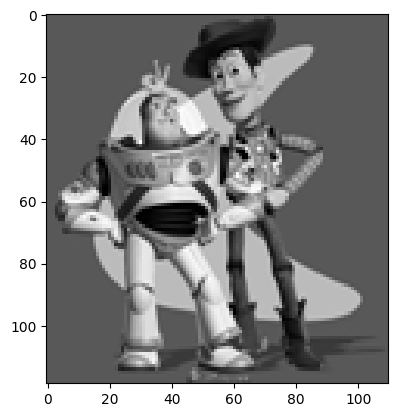

(119, 110, 3)


In [2]:
img = cv2.imread('toy/toy_problem.png') #read image
# img = cv2.cvtColor(img, (cv2.COLOR_BGR2GRAY)).astype(float) #convert bgr to rgb
# img = cv2.resize(img, (5,5))
plt.imshow(img)
plt.show()
print(img.shape)

In [3]:
def toy_problem(s):
    # Get image dimensions
    h, w = s.shape

    # Create im2ind matrix
    im2ind = np.reshape(np.arange(0, h*w), [h, w])

    # Initialize sparse matrix A and vector b
    A = scipy.sparse.lil_matrix((2*h*w + 1, h*w))
    b = np.zeros(2*h*w + 1)
    # Populate A and b with constraints for gradient objectives
    e = 0  # equation counter
    for i in range(h):
        for j in range(w):
            # Objective 1
            if j > 0:
                e += 1
                A[e, im2ind[i, j]] = 1
                A[e, im2ind[i, j-1]] = -1
                b[e] = s[i, j] - s[i, j-1]

            # Objective 2
            if i > 0:
                e += 1
                A[e, im2ind[i, j]] = 1
                A[e, im2ind[i-1, j]] = -1
                b[e] = s[i, j] - s[i-1, j]

    # objective 3
    e += 1
    A[e, im2ind[0, 0]] = 1
    b[e] = s[0, 0]

    # Solve for variables v
    v = scipy.sparse.linalg.lsqr(A, b)[0]

    # Create output image using solved values
    output_image = np.reshape(v, [h, w])
    # print(im2ind)
    # print(v)
    # print(b)

    return output_image

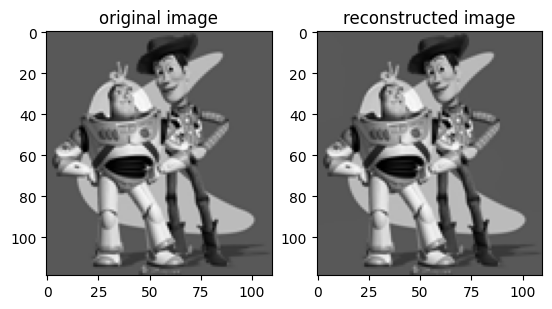

In [4]:
result_img = np.dstack((toy_problem(img[:,:,0].astype(float)),toy_problem(img[:,:,1].astype(float)),toy_problem(img[:,:,2].astype(float))))
fig, axes = plt.subplots(1,2)
axes[0].set_title("original image")
axes[0].imshow(img)
axes[1].set_title("reconstructed image")
axes[1].imshow(result_img.astype(np.uint8))

## Copy one source image into other target image

In [43]:
tree_img = cv2.imread('alpha/tree_image.jpg')
rgb_tree_img = cv2.cvtColor(tree_img, cv2.COLOR_BGR2RGB)
tree_img = cv2.resize(tree_img, (1280,853))
rgb_tree_img = cv2.resize(rgb_tree_img, (1280,853))
gray_tree_img = cv2.cvtColor(tree_img, cv2.COLOR_BGR2GRAY)

In [44]:
moon_img = cv2.imread('alpha/moon.jpg')
shift_filter = np.array([
    [1,0,0],
    [0,0,0],
    [0,0,0]
])
gray_moon_img = cv2.cvtColor(moon_img, cv2.COLOR_BGR2GRAY)

from scipy import ndimage

# Apply thresholding to the grayscale image
# _, thresh = cv2.threshold(gray_moon_img, 100, 180, cv2.THRESH_BINARY)

# Create a mask from the thresholded image
# mask = np.zeros_like(thresh, dtype=np.uint8)
# mask[thresh > 0] = 255

shifted_B_img = ndimage.convolve(moon_img[:,:,0], shift_filter, mode = 'constant', cval = 0.0)
shifted_G_img = ndimage.convolve(moon_img[:,:,1], shift_filter, mode = 'constant', cval = 0.0)
shifted_R_img = ndimage.convolve(moon_img[:,:,2], shift_filter, mode = 'constant', cval = 0.0)
for i in range(300):
  shifted_B_img = ndimage.convolve(shifted_B_img, shift_filter, mode = 'constant', cval = 0.0)
  shifted_G_img = ndimage.convolve(shifted_G_img, shift_filter, mode = 'constant', cval = 0.0)
  shifted_R_img = ndimage.convolve(shifted_R_img, shift_filter, mode = 'constant', cval = 0.0)

# shifted_image =(np.stack((shifted_B_img,shifted_G_img,shifted_R_img))) .astype(np.uint8)


In [45]:
mask = np.zeros((gray_moon_img.shape), dtype= np.uint8)
cv2.circle(mask, (480,118), 85, 1, -1, cv2.LINE_AA)


# Apply the mask to the original image
# masked_image = cv2.bitwise_and(moon_img, moon_img, mask=mask)
# print(masked_image.shape)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [46]:
shifted_image =(np.dstack((shifted_R_img,shifted_G_img,shifted_B_img))) .astype(np.uint8)

In [47]:
tmp = np.dstack((np.multiply(shifted_R_img, mask),
np.multiply(shifted_G_img, mask),
np.multiply(shifted_B_img, mask)))

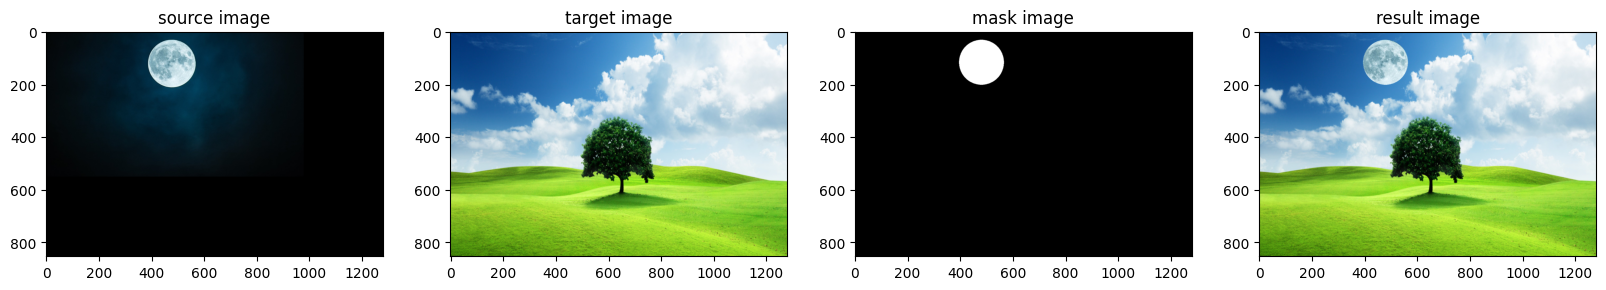

In [49]:
result_B = np.multiply(tree_img[:,:,0], (1-mask)) + np.multiply(shifted_B_img, mask)
result_G = np.multiply(tree_img[:,:,1], (1-mask)) + np.multiply(shifted_G_img, mask)
result_R = np.multiply(tree_img[:,:,2], (1-mask)) + np.multiply(shifted_R_img, mask)
result =(np.dstack((result_R,result_G,result_B))) .astype(np.uint8)
fig, axes = plt.subplots(1,4, figsize= (20,20) )
axes[0].set_title('source image')
axes[0].imshow(shifted_image)
axes[1].set_title('target image')
axes[1].imshow(rgb_tree_img)
axes[2].set_title('mask image')
axes[2].imshow(mask, cmap ='gray')
axes[3].set_title('result image')
axes[3].imshow(result)

## Alpha blending

In [51]:
# blur_mask = cv2.GaussianBlur(mask, (3, 3), 10)
# print(blur_mask)
# plt.imshow(blur_mask, cmap = 'gray')
# blur_mask = cv2.GaussianBlur(mask, (3, 3), 0)
# blur_mask = blur_mask.astype('float32')
from skimage import filters

blur_mask = filters.gaussian(mask, sigma=20)*255

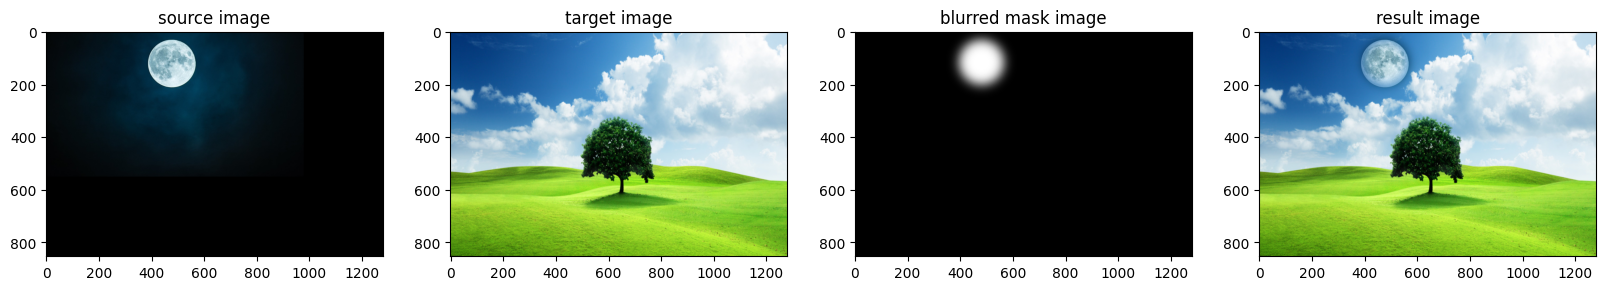

In [50]:
fn_result_B = np.multiply(tree_img[:,:,0], (1-blur_mask)) + np.multiply(shifted_B_img, blur_mask)
fn_result_G = np.multiply(tree_img[:,:,1], (1-blur_mask)) + np.multiply(shifted_G_img,blur_mask)
fn_result_R = np.multiply(tree_img[:,:,2], (1-blur_mask)) + np.multiply(shifted_R_img, blur_mask)
fn_result =(np.dstack((fn_result_R,fn_result_G,fn_result_B))).astype(np.uint8)
fig, axes = plt.subplots(1,4, figsize= (20,20) )
axes[0].set_title('source image')
axes[0].imshow(shifted_image)
axes[1].set_title('target image')
axes[1].imshow(rgb_tree_img)
axes[2].set_title('blurred mask image')
axes[2].imshow(blur_mask, cmap ='gray')
axes[3].set_title('result image')
axes[3].imshow(fn_result)

## Gradient domain blending

In [30]:
s = cv2.imread('gradient1/source_01_newsource.png')
t = cv2.imread('gradient1/target_01.jpg')
m = cv2.imread('gradient1/target_01_mask.png')

In [14]:
def gradient_domain_editing(S, T, mask):
    h, w = T.shape  # Assuming S, T, and mask are grayscale images with shape (h, w)
    
    # Create variable index mapping
    im2ind = np.arange(h * w).reshape(h, w)
    
    # Initialize sparse matrix A and vector b
    A = scipy.sparse.lil_matrix((2 * (h * w) + 1, h * w), dtype=np.float64)
    b = np.zeros(2 * (h * w) + 1, dtype=np.float64)
    
    # Equation counter
    e = 0
    for y in range(h):
        for x in range(w):
            if x + 1 < w:
                # Horizontal gradient
                A[e, im2ind[y, x]] = 1
                A[e, im2ind[y, x + 1]] = -1
                if mask[y, x]:
                    b[e] = S[y, x] - S[y, x + 1]
                else:
                    b[e] = T[y, x] - T[y, x + 1]
                e += 1

            if y + 1 < h:
                # Vertical gradient
                A[e, im2ind[y, x]] = 1
                A[e, im2ind[y + 1, x]] = -1
                if mask[y, x]:
                    b[e] = S[y, x] - S[y + 1, x]
                else:
                    b[e] = T[y, x] - T[y + 1, x]
                e += 1
    
    A[e, im2ind[0, 0]] = 1
    b[e] = T[0, 0]
    
    # Solve the least squares problem
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)[0]
    
    # Reshape the solution to the image shape
    N = np.reshape(v, (h, w))
    
    
    return np.clip(N, 0, 255).astype(np.uint8) 

### Example 1

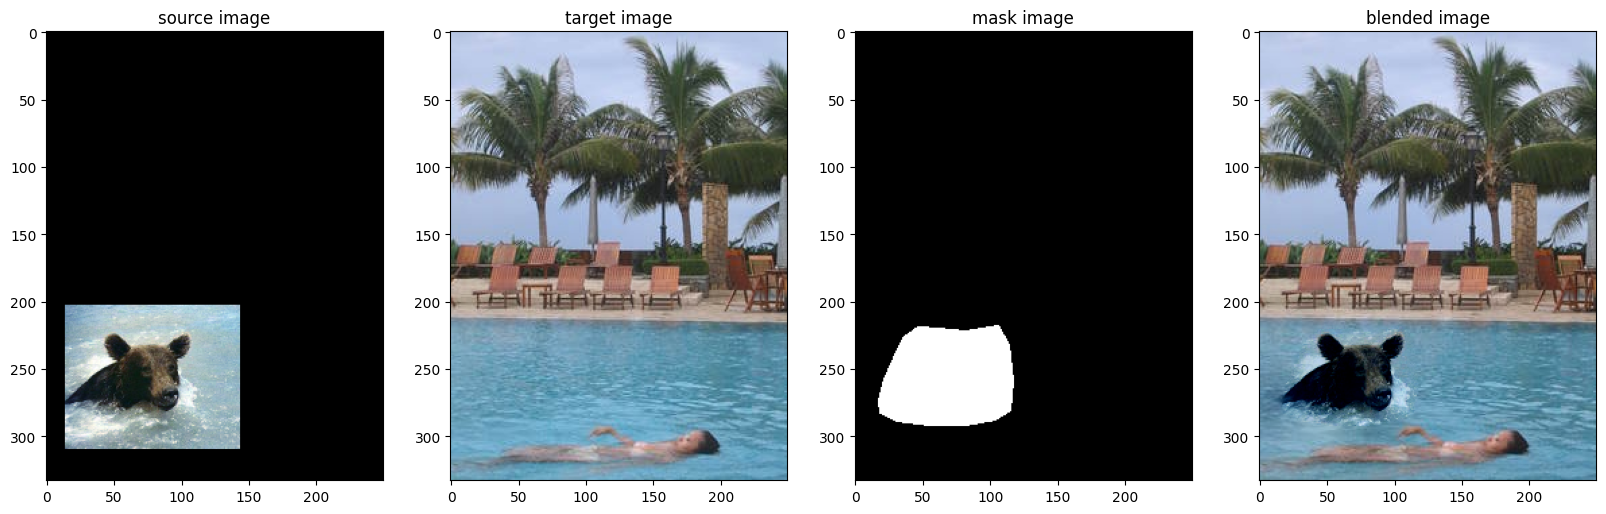

In [35]:
N_B = gradient_domain_editing(s[:,:,0].astype(np.float64), t[:,:,0].astype(np.float64),  m[:,:,0].astype(bool))
N_G = gradient_domain_editing(s[:,:,1].astype(np.float64), t[:,:,1].astype(np.float64),  m[:,:,1].astype(bool))
N_R = gradient_domain_editing(s[:,:,2].astype(np.float64), t[:,:,2].astype(np.float64),  m[:,:,2].astype(bool))
N = np.dstack((N_R, N_G, N_B))
fig, axes = plt.subplots(1,4, figsize= (20,20) )
axes[0].set_title('source image')
axes[0].imshow(cv2.cvtColor(s, cv2.COLOR_BGR2RGB))
axes[1].set_title('target image')
axes[1].imshow(cv2.cvtColor(t, cv2.COLOR_BGR2RGB))
axes[2].set_title('mask image')
axes[2].imshow(cv2.cvtColor(m, cv2.COLOR_BGR2RGB))
axes[3].set_title('blended image')
axes[3].imshow(N)

### Example 2

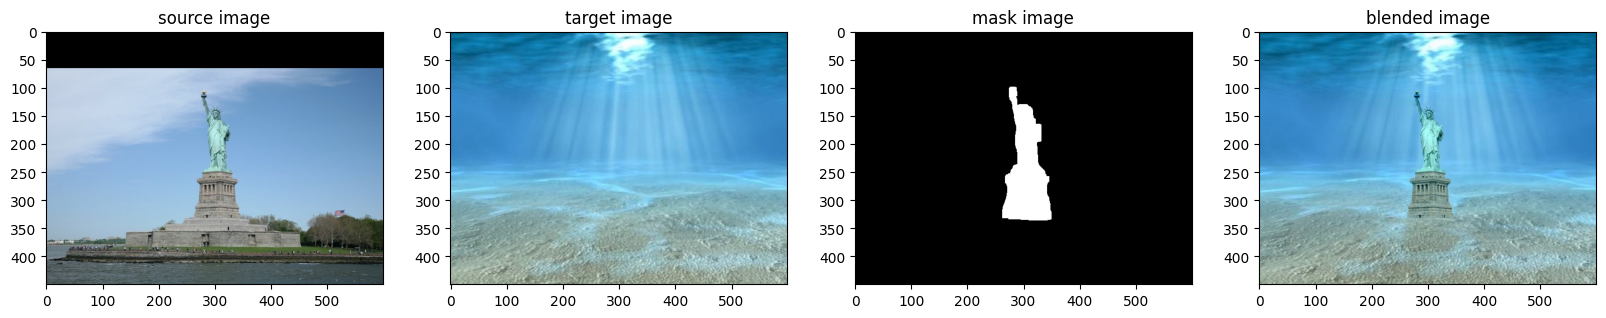

In [36]:
s = cv2.imread('gradient2/source1.jpg')
t = cv2.imread('gradient2/target1.jpg')
m = cv2.imread('gradient2/mask1.png')
y_max, x_max = t.shape[:-1]
y_min, x_min = 0, 0
x_range = x_max - x_min
y_range = y_max - y_min
offset = (0, 66)
M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
s = cv2.warpAffine(s, M, (x_range, y_range))

N_B = gradient_domain_editing(s[:,:,0].astype(np.float64), t[:,:,0].astype(np.float64),  m[:,:,0].astype(bool))
N_G = gradient_domain_editing(s[:,:,1].astype(np.float64), t[:,:,1].astype(np.float64),  m[:,:,1].astype(bool))
N_R = gradient_domain_editing(s[:,:,2].astype(np.float64), t[:,:,2].astype(np.float64),  m[:,:,2].astype(bool))
N = np.dstack((N_R, N_G, N_B))
fig, axes = plt.subplots(1,4, figsize= (20,20) )
axes[0].set_title('source image')
axes[0].imshow(cv2.cvtColor(s, cv2.COLOR_BGR2RGB))
axes[1].set_title('target image')
axes[1].imshow(cv2.cvtColor(t, cv2.COLOR_BGR2RGB))
axes[2].set_title('mask image')
axes[2].imshow(cv2.cvtColor(m, cv2.COLOR_BGR2RGB))
axes[3].set_title('blended image')
axes[3].imshow(N)

### Example 3

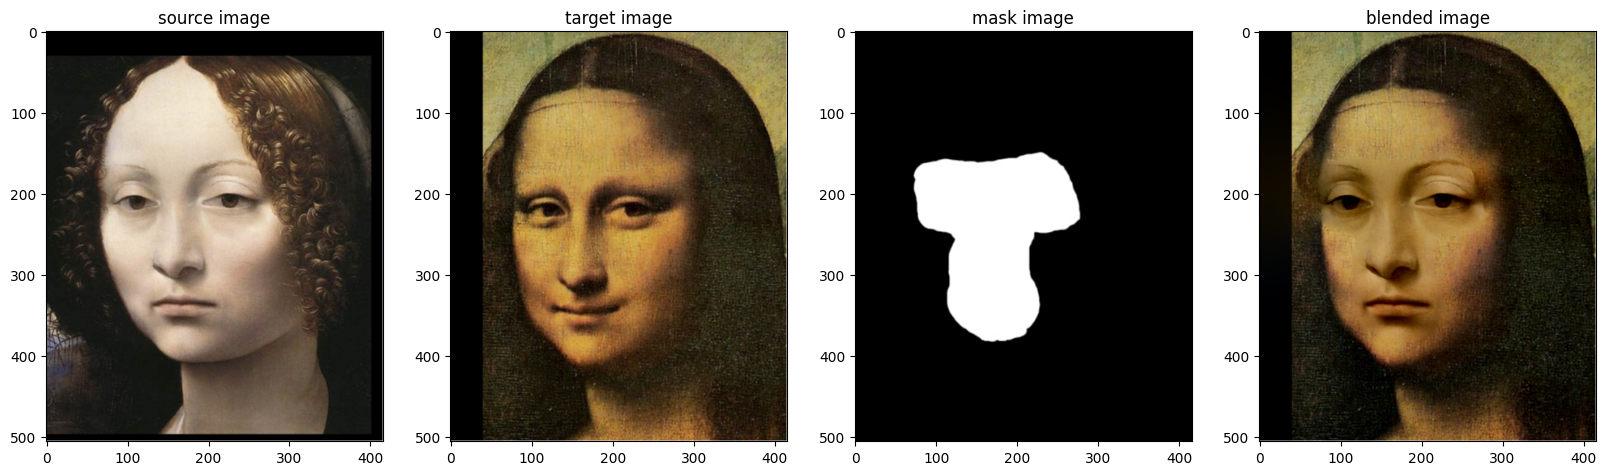

In [37]:
s = cv2.imread('test1/source.png')
t = cv2.imread('test1/target.png')
m = cv2.imread('test1/mask.png')

N_B = gradient_domain_editing(s[:,:,0].astype(np.float64), t[:,:,0].astype(np.float64),  m[:,:,0].astype(bool))
N_G = gradient_domain_editing(s[:,:,1].astype(np.float64), t[:,:,1].astype(np.float64),  m[:,:,1].astype(bool))
N_R = gradient_domain_editing(s[:,:,2].astype(np.float64), t[:,:,2].astype(np.float64),  m[:,:,2].astype(bool))
N = np.dstack((N_R, N_G, N_B))
fig, axes = plt.subplots(1,4, figsize= (20,20) )
axes[0].set_title('source image')
axes[0].imshow(cv2.cvtColor(s, cv2.COLOR_BGR2RGB))
axes[1].set_title('target image')
axes[1].imshow(cv2.cvtColor(t, cv2.COLOR_BGR2RGB))
axes[2].set_title('mask image')
axes[2].imshow(cv2.cvtColor(m, cv2.COLOR_BGR2RGB))
axes[3].set_title('blended image')
axes[3].imshow(N)


## Laplacian image blending